In [1]:
#요구 사항 확인
import sys

sys.version

'3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]'

In [2]:
#데이터 처리
import pandas as pd
import numpy as np

# 결측치 처리
#!pip install missingno
import missingno as msno

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates ## 그래프 그릴 때 날짜 관련

### 글꼴 설정
import matplotlib.font_manager as fm
#### 글꼴 경로 설정
font_path = 'C:/Users/jisu0/Downloads/maruburi/TTF\MaruBuri-Regular.ttf'
#### 폰트 이름 가져오기
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

In [3]:
# 경고 무시 ##가독성을 위해 실행되는 경고성 메시지 무시
import warnings
warnings.filterwarnings(action='ignore')
#warnings.filterwarnings(action='default')

In [4]:
# 모델 시각화 관련 라이브러리
#!pip install graphviz

In [5]:
# 예측 모델 관련 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# data

## import

In [6]:
# CSV 파일 경로
file_path = '분석과제5.xlsx'

# CSV 파일 읽기
df = pd.read_excel(file_path,header=[0,1])

## 전처리

In [7]:
df.shape

(53280, 21)

### 칼럼 이름 변경

In [8]:
# 멀티인덱스 하나로 합치기
col_list = list(map(lambda x: '_'.join(x[0:]),df.columns))
df.columns = col_list

### 데이터 형식 변환

In [9]:
# 가독성 편한 이름으로 변경
df = df.rename(columns={'측정일시_Unnamed: 0_level_1':'측정일시' ,
                        '#3호기_발전량':'3호기_발전량',
                        '#3호기_Outlet Sox\n(배출허용기준: 15ppm)':'3호기_Outlet Sox',
                        '#3호기_배출정상\n여부':'3호기_배출정상_여부',
                        '#4호기_발전량':'4호기_발전량',
                        '#4호기_Outlet Sox\n(배출허용기준: 25ppm)':'4호기_Outlet Sox',
                        '#4호기_배출정상\n여부':'4호기_배출정상_여부',
                        '#5호기_발전량':'5호기_발전량',
                        '#5호기_Outlet Sox\n(배출허용기준:\n48ppm)':'5호기_Outlet Sox',
                        '#5호기_배출정상\n여부':'5호기_배출정상_여부',
                        '#6호기_발전량':'6호기_발전량',
                        '#6호기_Outlet Sox\n(배출허용기준:\n48ppm)':'6호기_Outlet Sox',
                        '#6호기_배출정상\n여부':'6호기_배출정상_여부',
                        'Inlet Sox_#3호기':'3호기_Inlet Sox',
                        'Inlet Sox_#4호기':'4호기_Inlet Sox',
                        'Inlet Sox_#5호기':'5호기_Inlet Sox',
                        'Inlet Sox_#6호기':'6호기_Inlet Sox',
                        '석회석(탈황제:ton)_#3호기':'3호기_석회석(탈황제:ton)',
                        '석회석(탈황제:ton)_#4호기':'4호기_석회석(탈황제:ton)',
                        '석회석(탈황제:ton)_#5호기':'5호기_석회석(탈황제:ton)',
                        '석회석(탈황제:ton)_#6호기':'6호기_석회석(탈황제:ton)'})

In [10]:
# 표 데이터 데이터 프레임 형식으로 변환

## 호기 리스트
units = ['3호기', '4호기', '5호기', '6호기']

## 빈 리스트 생성
data = []

## 각 호기의 데이터를 분리하여 단일 인덱스로 변환
for unit in units:
    temp_df = pd.DataFrame({
        '측정일시': df['측정일시'],
        '호기': unit,
        '발전출력(MW)': df[f'{unit}_발전량'],
        '운전상태': df[f'{unit}_배출정상_여부'],
        'Inlet_SO2(ppm)': df[f'{unit}_Inlet Sox'],
        'Slurry_투입량(ton)': df[f'{unit}_석회석(탈황제:ton)'],
        'Outlet_SO2(ppm)': df[f'{unit}_Outlet Sox']
    })
    data.append(temp_df)
result_df = pd.concat(data, ignore_index=True)

In [11]:
result_df.head()

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm)
0,2023-09-01 00:00:00,3호기,474,정상,189.449444,5.709698,0.68
1,2023-09-01 00:05:00,3호기,486,정상,188.298000,3.073769,0.36
2,2023-09-01 00:10:00,3호기,510,정상,186.304000,3.430059,0.4
3,2023-09-01 00:15:00,3호기,518,정상,188.133846,10.615394,1.74
4,2023-09-01 00:20:00,3호기,518,정상,191.394286,11.991851,1.52


In [12]:
result_df.shape

(213120, 7)

### before 1T Outlet_SO2

In [14]:
# 1측정 후 Outlet_SO2, 지금 넣은 slurry는 다음에 영향을 미치기 떄문

In [34]:
# 호기, 시간 별 정렬
result_df_sort = result_df.sort_values(['호기','측정일시'],ascending=True)

# 1측정 후 SO2, 지금 넣는 slurry의 영향은 다음에 나타나기 때문
result_df_sort['Outlet_SO2_rol_1(ppm)'] = result_df_sort['Outlet_SO2(ppm)'].shift(-1)
# 앞 데이터가 다른 호기면 None 처리 
result_df_sort.loc[(result_df_sort['호기'] != result_df_sort['호기'].shift(1)),'Outlet_SO2_rol_1(ppm)'] = None
## 첫 data까지 null, hard coding으로 처리
result_df_sort.loc[0,'Outlet_SO2_rol_1(ppm)'] = 0.36

#이상치 제거 ## 뒤에서 제거할 운전 상태 - 인 것들의 Outlet_SO2이 - 경우 제거
result_df_sort = result_df_sort[result_df_sort['Outlet_SO2_rol_1(ppm)']!='-']

In [40]:
#확인
print(result_df_sort.shape)
result_df_sort.loc[(result_df_sort['호기'] != result_df_sort['호기'].shift(1))]

(213085, 8)


,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)
0,2023-09-01,3호기,474,정상,189.449444,5.709698,0.68,0.36
53280,2023-09-01,4호기,0,정상,203.080534,5.336000,1.14,None
106560,2023-09-01,5호기,456,정상,185.768341,0.027419,15.06,None
159840,2023-09-01,6호기,443,정상,240.874655,5.558224,13.37,None


In [45]:
result_df_sort[53272:53275]

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)
53279,2024-02-29 23:55:00,3호기,420,정상,221.117308,20.196117,5.01,1.14
53280,2023-09-01 00:00:00,4호기,0,정상,203.080534,5.336000,1.14,None
53281,2023-09-01 00:05:00,4호기,0,정상,203.329203,4.284000,1.61,1.74


In [37]:
result_df_sort.head()

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)
0,2023-09-01 00:00:00,3호기,474,정상,189.449444,5.709698,0.68,0.36
1,2023-09-01 00:05:00,3호기,486,정상,188.298000,3.073769,0.36,0.4
2,2023-09-01 00:10:00,3호기,510,정상,186.304000,3.430059,0.4,1.74
3,2023-09-01 00:15:00,3호기,518,정상,188.133846,10.615394,1.74,1.52
4,2023-09-01 00:20:00,3호기,518,정상,191.394286,11.991851,1.52,0.82


In [38]:
result_df_sort.tail()

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)
213115,2024-02-29 23:35:00,6호기,1,정상,2.521914,0.0,1.89,3.18
213116,2024-02-29 23:40:00,6호기,1,정상,2.531338,NaN,3.18,3.47
213117,2024-02-29 23:45:00,6호기,1,정상,2.450782,0.0,3.47,1.1
213118,2024-02-29 23:50:00,6호기,1,정상,2.571517,NaN,1.1,1.99
213119,2024-02-29 23:55:00,6호기,1,정상,2.433664,0.0,1.99,None


### 결측치

In [21]:
#결측치 확인
print(result_df_sort.isnull().sum())

측정일시                         0
호기                           0
발전출력(MW)                     0
운전상태                         0
Inlet_SO2(ppm)           19711
Slurry_투입량(ton)          13740
Outlet_SO2(ppm)              0
Outlet_SO2_rol_1(ppm)        5
dtype: int64


In [22]:
result_df_sort[result_df_sort.isnull().any(axis=1)]
# 결측치 포함 행 수 : 20120

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)
0,2023-09-01 00:00:00,3호기,474,정상,189.449444,5.709698,0.68,None
7617,2023-09-27 10:45:00,3호기,521,보수중,NaN,NaN,1.44,2.01
7618,2023-09-27 10:50:00,3호기,526,보수중,NaN,NaN,2.01,1.79
7619,2023-09-27 10:55:00,3호기,524,보수중,NaN,NaN,1.79,1.81
7620,2023-09-27 11:00:00,3호기,519,보수중,NaN,NaN,1.81,2.17
...,...,...,...,...,...,...,...,...
213112,2024-02-29 23:20:00,6호기,1,정상,2.796167,NaN,1.7,2.98
213114,2024-02-29 23:30:00,6호기,1,정상,2.464449,NaN,0.37,1.89
213116,2024-02-29 23:40:00,6호기,1,정상,2.531338,NaN,3.18,3.47
213118,2024-02-29 23:50:00,6호기,1,정상,2.571517,NaN,1.1,1.99


In [23]:
# 두 변수갑이 0인 행은 존재, null은 0이 아닌 것으로 간주
print(result_df_sort[result_df_sort['Inlet_SO2(ppm)']==0].shape)
print(result_df_sort[result_df_sort['Slurry_투입량(ton)']==0].shape)

(4, 8)
(1157, 8)


<Axes: >

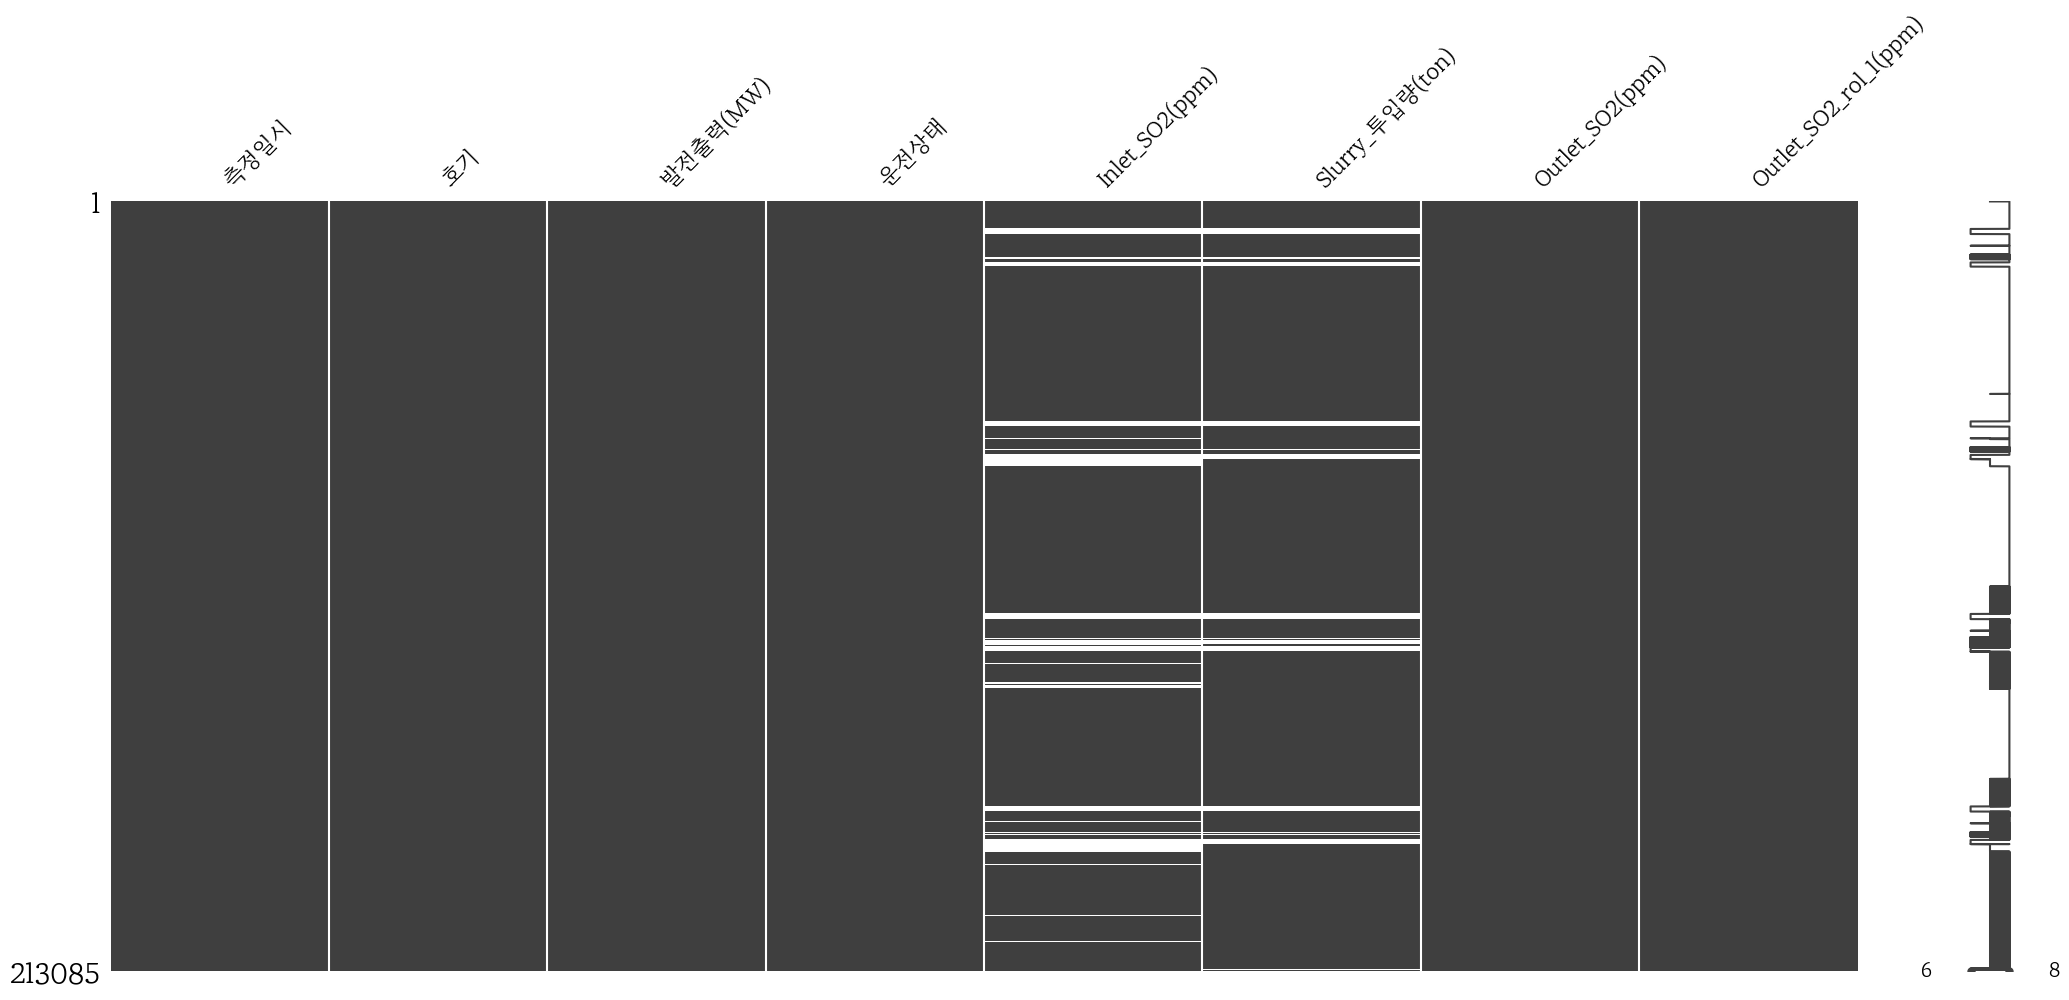

In [24]:
# 결측치 시각화
msno.matrix(result_df_sort)

In [25]:
# 결측치 대부분이 분석의 주요 대상인 희석제 투입량의 결측치 이기 때문에 결측치 전부 제거
result_df_1 = result_df_sort.dropna()

In [26]:
print(result_df.shape)
print(result_df_1.shape)

print('제거 데이터 비중 : ',26940/213120*100, "%")

(213120, 7)
(192961, 8)
제거 데이터 비중 :  12.640765765765765 %


### 이상치

In [27]:
result_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192961 entries, 1 to 213117
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   측정일시                   192961 non-null  datetime64[ns]
 1   호기                     192961 non-null  object        
 2   발전출력(MW)               192961 non-null  object        
 3   운전상태                   192961 non-null  object        
 4   Inlet_SO2(ppm)         192961 non-null  float64       
 5   Slurry_투입량(ton)        192961 non-null  float64       
 6   Outlet_SO2(ppm)        192961 non-null  object        
 7   Outlet_SO2_rol_1(ppm)  192961 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 13.2+ MB


In [28]:
result_df_1['측정일시'].unique()
#datatime으로 되는 것을 보아 특이값 없음

<DatetimeArray>
['2023-09-01 00:05:00', '2023-09-01 00:10:00', '2023-09-01 00:15:00',
 '2023-09-01 00:20:00', '2023-09-01 00:25:00', '2023-09-01 00:30:00',
 '2023-09-01 00:35:00', '2023-09-01 00:40:00', '2023-09-01 00:45:00',
 '2023-09-01 00:50:00',
 ...
 '2023-09-06 19:35:00', '2023-09-06 19:40:00', '2023-09-06 19:45:00',
 '2023-10-10 13:55:00', '2023-10-20 14:25:00', '2023-10-20 14:35:00',
 '2023-10-22 09:50:00', '2023-10-22 10:00:00', '2023-10-22 10:10:00',
 '2023-10-30 14:30:00']
Length: 49341, dtype: datetime64[ns]

In [29]:
result_df_1['호기'].unique()

array(['3호기', '4호기', '5호기', '6호기'], dtype=object)

#### 문자형 변수

##### 운전상태

In [30]:
result_df_1['운전상태'].unique()

array(['정상', '교정중', '보수중', '-', '전원단절'], dtype=object)

In [31]:
result_df_1[result_df_1['운전상태']!="보수중"]

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)
1,2023-09-01 00:05:00,3호기,486,정상,188.298000,3.073769,0.36,0.4
2,2023-09-01 00:10:00,3호기,510,정상,186.304000,3.430059,0.4,1.74
3,2023-09-01 00:15:00,3호기,518,정상,188.133846,10.615394,1.74,1.52
4,2023-09-01 00:20:00,3호기,518,정상,191.394286,11.991851,1.52,0.82
5,2023-09-01 00:25:00,3호기,526,정상,192.784706,6.646228,0.82,0.83
...,...,...,...,...,...,...,...,...
213109,2024-02-29 23:05:00,6호기,1,정상,2.484906,0.000000,1.03,2.88
213111,2024-02-29 23:15:00,6호기,1,정상,2.487636,0.000000,3.51,1.7
213113,2024-02-29 23:25:00,6호기,1,정상,2.614689,0.000000,2.98,0.37
213115,2024-02-29 23:35:00,6호기,1,정상,2.521914,0.000000,1.89,3.18


In [32]:
result_df_1[result_df_1['운전상태']=='전원단절']

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)
55109,2023-09-07 08:25:00,4호기,0,전원단절,191.429789,5.676000,0,0.08
55110,2023-09-07 08:30:00,4호기,0,전원단절,183.885637,4.908000,0.08,0.26
108390,2023-09-07 08:30:00,5호기,0,전원단절,4.087699,0.028872,0,0
161670,2023-09-07 08:30:00,6호기,469,전원단절,201.030801,6.638976,19.91,16.71


In [33]:
result_df_1[result_df_1['운전상태']=='교정중']

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)
128,2023-09-01 10:40:00,3호기,476,교정중,187.517273,10.106489,0.33,2.15
416,2023-09-02 10:40:00,3호기,478,교정중,173.507647,4.041579,0.74,2.68
704,2023-09-03 10:40:00,3호기,478,교정중,182.786552,4.102020,2.02,3.14
992,2023-09-04 10:40:00,3호기,527,교정중,202.352381,5.078989,4.26,4.06
1280,2023-09-05 10:40:00,3호기,479,교정중,255.578400,5.391709,4.24,4.26
...,...,...,...,...,...,...,...,...
211873,2024-02-25 16:05:00,6호기,1,교정중,2.646397,40.244585,0.06,5.5
212161,2024-02-26 16:05:00,6호기,1,교정중,1.322597,0.000000,2.4,2.77
212448,2024-02-27 16:00:00,6호기,1,교정중,2.535075,0.000000,1.43,0.59
212737,2024-02-28 16:05:00,6호기,1,교정중,7.388979,0.000000,0.23,3.59


In [34]:
result_df_1[result_df_1['운전상태']=='-']

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)
1680,2023-09-06 20:00:00,3호기,-,-,163.016250,8.874210,-,2.66
54958,2023-09-06 19:50:00,4호기,-,-,173.428835,3.314000,-,0.19
58348,2023-09-18 14:20:00,4호기,-,-,194.755206,3.446000,-,1.31
60007,2023-09-24 08:35:00,4호기,-,-,6.487762,0.020000,-,0
76274,2023-11-16 20:10:00,4호기,-,-,265.945707,0.996000,-,1.16
80321,2023-11-30 21:25:00,4호기,-,-,235.041526,6.309000,-,0.86
108240,2023-09-06 20:00:00,5호기,-,-,4.319412,0.029184,-,0
130889,2023-11-21 11:25:00,5호기,-,-,250.906766,0.022932,-,63.62
147122,2024-01-16 20:10:00,5호기,-,-,3.077590,0.019542,-,49.23
147158,2024-01-16 23:10:00,5호기,-,-,3.046381,0.020261,-,159.38


In [35]:
# 운전상태가 정상이 아닌 것들은 제거
print(result_df_1.shape)
result_df_1 = result_df_1[result_df_1['운전상태']=="정상"]
print(result_df_1.shape)

print('제거 데이터 비중 : ', (193000-184269)/193000*100,'%')

(192961, 8)
(184250, 8)
제거 데이터 비중 :  4.523834196891192 %


#### 수치형 변수

##### Inlet_SO2(ppm)

In [36]:
result_df_1[result_df_1['Inlet_SO2(ppm)'] < 0]

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)
12711,2023-10-12 03:15:00,3호기,1,정상,-0.270000,4.370852,0.95,1.53
12712,2023-10-12 03:20:00,3호기,1,정상,-0.258000,4.452561,1.53,2.79
12713,2023-10-12 03:25:00,3호기,1,정상,-0.240000,4.409002,2.79,5.47
12714,2023-10-12 03:30:00,3호기,1,정상,-0.272000,5.009467,5.47,7.94
12715,2023-10-12 03:35:00,3호기,1,정상,-0.061667,5.184084,7.94,6.54
...,...,...,...,...,...,...,...,...
103276,2024-02-18 14:20:00,4호기,0,정상,-26.702836,0.024000,34.22,62.63
103277,2024-02-18 14:25:00,4호기,0,정상,-27.862599,0.024000,62.63,43.44
124825,2023-10-31 10:05:00,5호기,0,정상,-123.148674,0.025640,316.51,170.5
196303,2024-01-02 14:35:00,6호기,477,정상,-42.769788,1.512690,9.83,10.67


In [37]:
# Inlet_SO2(ppm) - 음수값 존재. 데이터에 대해 정확한 명세는 없으나, 직관적으로 이상치로 판단
print(result_df_1.shape)
print(result_df_1[result_df_1['Inlet_SO2(ppm)']< 0].shape)
result_df_1 = result_df_1[result_df_1['Inlet_SO2(ppm)'] > 0]
print(result_df_1.shape)

(184250, 8)
(5858, 8)
(178390, 8)


##### 발전출력(MW)

In [38]:
result_df_1[result_df_1['발전출력(MW)']==0]

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)
53281,2023-09-01 00:05:00,4호기,0,정상,203.329203,4.284000,1.61,1.74
53282,2023-09-01 00:10:00,4호기,0,정상,203.647826,3.762000,1.74,2.04
53283,2023-09-01 00:15:00,4호기,0,정상,206.172152,4.248571,2.04,1.49
53284,2023-09-01 00:20:00,4호기,0,정상,209.051893,10.402000,1.49,1.23
53285,2023-09-01 00:25:00,4호기,0,정상,211.833002,11.826000,1.23,0.93
...,...,...,...,...,...,...,...,...
156736,2024-02-19 05:20:00,5호기,0,정상,38.300722,0.025008,2,1.06
156737,2024-02-19 05:25:00,5호기,0,정상,38.287724,0.023762,1.06,3.17
156738,2024-02-19 05:30:00,5호기,0,정상,42.506612,0.024000,3.17,1.84
156739,2024-02-19 05:35:00,5호기,0,정상,46.783763,0.023711,1.84,3.54


In [39]:
test = result_df_1[result_df_1['발전출력(MW)']<100]

In [40]:
test['발전출력(MW)'].value_counts()

발전출력(MW)
0     61815
1     13112
2        14
4         4
9         4
      ...  
63        1
70        1
30        1
15        1
25        1
Name: count, Length: 68, dtype: int64

In [41]:
# 운전상태가 정상이지만 발전출력이 0 인것도 정상 판단.
# 데이터 비중이 높아서, 특정한 상태가 있는 것으로 판단.

In [42]:
result_df_1[result_df_1['발전출력(MW)']<0]

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)


##### Slurry_투입량(ton)

In [43]:
# 'Slurry_투입량' 이 음수인 것 삭제
result_df_1['Slurry_투입량(ton)'].min()

-5.143732866

In [44]:
result_df_1[result_df_1['Slurry_투입량(ton)']>40]

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)
146,2023-09-01 12:10:00,3호기,309,정상,171.785500,43.832422,1.32,0.42
147,2023-09-01 12:15:00,3호기,316,정상,168.408077,42.298881,0.42,0.24
148,2023-09-01 12:20:00,3호기,333,정상,163.602258,43.017641,0.24,0.21
149,2023-09-01 12:25:00,3호기,303,정상,165.532174,42.963722,0.21,0.07
150,2023-09-01 12:30:00,3호기,322,정상,167.179524,45.056634,0.07,0.06
...,...,...,...,...,...,...,...,...
212152,2024-02-26 15:20:00,6호기,1,정상,2.653801,40.259580,3.61,3.17
212153,2024-02-26 15:25:00,6호기,1,정상,2.677786,40.258650,3.17,1.47
212154,2024-02-26 15:30:00,6호기,1,정상,2.666265,40.257076,1.47,4.37
212155,2024-02-26 15:35:00,6호기,1,정상,2.695858,40.258317,4.37,2.01


In [45]:
# Slurry_투입량(ton) 분포가 40 부근에서 특이성을 띄나,정상 판단

In [46]:
# Slurry_투입량(ton) & Outlet_SO2(ppm)이 둘다 0인 것은 이상치로 간주
result_df_1[(result_df_1['Slurry_투입량(ton)']==0)&(result_df_1['Outlet_SO2(ppm)']==0)&(result_df_1['Inlet_SO2(ppm)']!=0)]

,측정일시,호기,발전출력(MW),운전상태,Inlet_SO2(ppm),Slurry_투입량(ton),Outlet_SO2(ppm),Outlet_SO2_rol_1(ppm)
74598,2023-11-11 00:30:00,4호기,0,정상,8.334176,0.0,0,0
74606,2023-11-11 01:10:00,4호기,0,정상,6.714014,0.0,0,0
74610,2023-11-11 01:30:00,4호기,0,정상,7.157977,0.0,0,0
74613,2023-11-11 01:45:00,4호기,0,정상,6.580715,0.0,0,0
74615,2023-11-11 01:55:00,4호기,0,정상,7.116502,0.0,0,0
...,...,...,...,...,...,...,...,...
212730,2024-02-28 15:30:00,6호기,1,정상,7.658512,0.0,0,0
212731,2024-02-28 15:35:00,6호기,1,정상,7.780492,0.0,0,0
212733,2024-02-28 15:45:00,6호기,1,정상,7.780492,0.0,0,0
212734,2024-02-28 15:50:00,6호기,1,정상,7.780492,0.0,0,0


In [47]:
print(result_df_1.shape)
result_df_1 = result_df_1[~((result_df_1['Slurry_투입량(ton)']==0)&(result_df_1['Outlet_SO2(ppm)']==0))]
result_df_1 = result_df_1[(result_df_1['Slurry_투입량(ton)']>=0)]
print(result_df_1.shape)

print('제거 데이터 비중 :',(178409 - 174071)/178409*100,'%')

(178390, 8)
(174052, 8)
제거 데이터 비중 : 2.4314916848365273 %


##### 'Outlet_SO2(ppm)

In [48]:
print(result_df_1['Outlet_SO2(ppm)'].min())
print(result_df_1['Outlet_SO2(ppm)'].max())

0
8555.9


In [49]:
# Inlet_SO2가 Outlet_SO2보다 작은 경우 이상치로 판단
#print(result_df_1.shape)
#result_df_1 = result_df_1[(result_df_1['Inlet_SO2(ppm)'] > result_df_1['Outlet_SO2(ppm)'])]
#print(result_df_1.shape)

In [50]:
# 편의성을 위해 수치형 변수 실수화
result_df_1['발전출력(MW)'] = result_df_1['발전출력(MW)'].astype('float')
result_df_1['Outlet_SO2(ppm)'] = result_df_1['Outlet_SO2(ppm)'].astype('float')

###### 데이터 시각화

###### 변수별

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(17, 9))

sns.distplot(result_df_1['발전출력(MW)'], ax=ax[0,0])
sns.distplot(result_df_1['Inlet_SO2(ppm)'], ax=ax[0,1])
sns.distplot(result_df_1['Slurry_투입량(ton)'], ax=ax[1,0])
sns.distplot(result_df_1['Outlet_SO2(ppm)'], ax=ax[1,1])

plt.show()

###### 발전소별 시계열 파악

In [ ]:
result_df_1['호기'].unique()

In [ ]:
result_df_no_3 = result_df_1[result_df_1['호기']=='3호기']
result_df_no_4 = result_df_1[result_df_1['호기']=='4호기']
result_df_no_5 = result_df_1[result_df_1['호기']=='5호기']
result_df_no_6 = result_df_1[result_df_1['호기']=='6호기']

###### 3호기

In [ ]:
%%time

# 측정일시를 문자열로 변환
result_df_no_3['측정일시'] = result_df_no_3['측정일시'].dt.strftime('%Y-%m-%d %H:%M')

f, ax = plt.subplots(2, 2, figsize=(34, 18))

# Inlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_3, x='측정일시', y='Inlet_SO2(ppm)', linewidth=2, label='Inlet_SO2(ppm)', color='red', ax=ax[0, 0])
ax[0, 0].set_title('Inlet_SO2(ppm)', fontsize=20)
ax[0, 0].set_xticks(result_df_no_3['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 0].set_xticklabels(result_df_no_3['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Slurry_투입량(ton) 그래프
sns.lineplot(data=result_df_no_3, x='측정일시', y='Slurry_투입량(ton)', linewidth=2, label='Slurry_투입량(ton)', ax=ax[0, 1])
ax[0, 1].set_title('Slurry_투입량(ton)', fontsize=20)
ax[0, 1].set_xticks(result_df_no_3['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 1].set_xticklabels(result_df_no_3['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Outlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_3, x='측정일시', y='Outlet_SO2(ppm)', linewidth=2, label='Outlet_SO2(ppm)', color='green', ax=ax[1, 0])
ax[1, 0].set_title('Outlet_SO2(ppm)', fontsize=20)
ax[1, 0].set_xticks(result_df_no_3['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 0].set_xticklabels(result_df_no_3['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# 발전출력(MW) 그래프
sns.lineplot(data=result_df_no_3, x='측정일시', y='발전출력(MW)', linewidth=2, label='발전출력(MW)', color='black', ax=ax[1, 1])
ax[1, 1].set_title('발전출력(MW)', fontsize=20)
ax[1, 1].set_xticks(result_df_no_3['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 1].set_xticklabels(result_df_no_3['측정일시'][::3000], rotation=45, ha='right', fontsize=10)


# 각 축에 그리드 추가
for axis in ax.flat:
    axis.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

###### 4호기

In [ ]:
%%time

# 측정일시를 문자열로 변환
result_df_no_4['측정일시'] = result_df_no_4['측정일시'].dt.strftime('%Y-%m-%d %H')

f, ax = plt.subplots(2, 2, figsize=(34, 18))

# Inlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_4, x='측정일시', y='Inlet_SO2(ppm)', linewidth=2, label='Inlet_SO2(ppm)', color='red', ax=ax[0, 0])
ax[0, 0].set_title('Inlet_SO2(ppm)', fontsize=20)
ax[0, 0].set_xticks(result_df_no_4['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 0].set_xticklabels(result_df_no_4['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Slurry_투입량(ton) 그래프
sns.lineplot(data=result_df_no_4, x='측정일시', y='Slurry_투입량(ton)', linewidth=2, label='Slurry_투입량(ton)', ax=ax[0, 1])
ax[0, 1].set_title('Slurry_투입량(ton)', fontsize=20)
ax[0, 1].set_xticks(result_df_no_4['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 1].set_xticklabels(result_df_no_4['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Outlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_4, x='측정일시', y='Outlet_SO2(ppm)', linewidth=2, label='Outlet_SO2(ppm)', color='green', ax=ax[1, 0])
ax[1, 0].set_title('Outlet_SO2(ppm)', fontsize=20)
ax[1, 0].set_xticks(result_df_no_4['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 0].set_xticklabels(result_df_no_4['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# 발전출력(MW) 그래프
sns.lineplot(data=result_df_no_4, x='측정일시', y='발전출력(MW)', linewidth=2, label='발전출력(MW)', color='black', ax=ax[1, 1])
ax[1, 1].set_title('발전출력(MW)', fontsize=20)
ax[1, 1].set_xticks(result_df_no_4['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 1].set_xticklabels(result_df_no_4['측정일시'][::3000], rotation=45, ha='right', fontsize=10)


# 각 축에 그리드 추가
for axis in ax.flat:
    axis.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

###### 5호기

In [ ]:
%%time

# 측정일시를 문자열로 변환
result_df_no_5['측정일시'] = result_df_no_5['측정일시'].dt.strftime('%Y-%m-%d %H')

f, ax = plt.subplots(2, 2, figsize=(34, 18))

# Inlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_5, x='측정일시', y='Inlet_SO2(ppm)', linewidth=2, label='Inlet_SO2(ppm)', color='red', ax=ax[0, 0])
ax[0, 0].set_title('Inlet_SO2(ppm)', fontsize=20)
ax[0, 0].set_xticks(result_df_no_5['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 0].set_xticklabels(result_df_no_5['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Slurry_투입량(ton) 그래프
sns.lineplot(data=result_df_no_5, x='측정일시', y='Slurry_투입량(ton)', linewidth=2, label='Slurry_투입량(ton)', ax=ax[0, 1])
ax[0, 1].set_title('Slurry_투입량(ton)', fontsize=20)
ax[0, 1].set_xticks(result_df_no_5['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 1].set_xticklabels(result_df_no_5['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Outlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_5, x='측정일시', y='Outlet_SO2(ppm)', linewidth=2, label='Outlet_SO2(ppm)', color='green', ax=ax[1, 0])
ax[1, 0].set_title('Outlet_SO2(ppm)', fontsize=20)
ax[1, 0].set_xticks(result_df_no_5['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 0].set_xticklabels(result_df_no_5['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# 발전출력(MW) 그래프
sns.lineplot(data=result_df_no_5, x='측정일시', y='발전출력(MW)', linewidth=2, label='발전출력(MW)', color='black', ax=ax[1, 1])
ax[1, 1].set_title('발전출력(MW)', fontsize=20)
ax[1, 1].set_xticks(result_df_no_5['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 1].set_xticklabels(result_df_no_5['측정일시'][::3000], rotation=45, ha='right', fontsize=10)


# 각 축에 그리드 추가
for axis in ax.flat:
    axis.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

###### 6호기

In [ ]:
%%time

# 측정일시를 문자열로 변환
result_df_no_6['측정일시'] = result_df_no_6['측정일시'].dt.strftime('%Y-%m-%d %H')

f, ax = plt.subplots(2, 2, figsize=(34, 18))

# Inlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_6, x='측정일시', y='Inlet_SO2(ppm)', linewidth=2, label='Inlet_SO2(ppm)', color='red', ax=ax[0, 0])
ax[0, 0].set_title('Inlet_SO2(ppm)', fontsize=20)
ax[0, 0].set_xticks(result_df_no_6['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 0].set_xticklabels(result_df_no_6['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Slurry_투입량(ton) 그래프
sns.lineplot(data=result_df_no_6, x='측정일시', y='Slurry_투입량(ton)', linewidth=2, label='Slurry_투입량(ton)', ax=ax[0, 1])
ax[0, 1].set_title('Slurry_투입량(ton)', fontsize=20)
ax[0, 1].set_xticks(result_df_no_6['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 1].set_xticklabels(result_df_no_6['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Outlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_6, x='측정일시', y='Outlet_SO2(ppm)', linewidth=2, label='Outlet_SO2(ppm)', color='green', ax=ax[1, 0])
ax[1, 0].set_title('Outlet_SO2(ppm)', fontsize=20)
ax[1, 0].set_xticks(result_df_no_6['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 0].set_xticklabels(result_df_no_6['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# 발전출력(MW) 그래프
sns.lineplot(data=result_df_no_6, x='측정일시', y='발전출력(MW)', linewidth=2, label='발전출력(MW)', color='black', ax=ax[1, 1])
ax[1, 1].set_title('발전출력(MW)', fontsize=20)
ax[1, 1].set_xticks(result_df_no_6['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 1].set_xticklabels(result_df_no_6['측정일시'][::3000], rotation=45, ha='right', fontsize=10)


# 각 축에 그리드 추가
for axis in ax.flat:
    axis.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##### IQR 방법을 사용하여 이상치를 탐지한 후, 해당 날짜를 제거

In [52]:
# 빈 datetime은 제외하고 그리려고 날짜변수 문자화(그래프 이쁘게 그리려고), 원본 데이터 관리
result_df_no_3 = result_df_1[result_df_1['호기']=='3호기']
result_df_no_4 = result_df_1[result_df_1['호기']=='4호기']
result_df_no_5 = result_df_1[result_df_1['호기']=='5호기']
result_df_no_6 = result_df_1[result_df_1['호기']=='6호기']

In [53]:
def detect_and_remove_outliers(df, columns, threshold=1.5):
    outlier_indices = []
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outlier_step = threshold * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = list(set(outlier_indices))
    df = df.drop(outlier_indices, axis=0).reset_index(drop=True)
    
    return df, outlier_indices

In [54]:
# Define the columns you want to check for outliers
columns_to_check = ['Inlet_SO2(ppm)', 'Slurry_투입량(ton)', 'Outlet_SO2(ppm)', '발전출력(MW)']

# Detect and remove outliers
result_df_no_3_clean, outlier_indices = detect_and_remove_outliers(result_df_no_3, columns_to_check)
result_df_no_4_clean, outlier_indices = detect_and_remove_outliers(result_df_no_4, columns_to_check)
result_df_no_5_clean, outlier_indices = detect_and_remove_outliers(result_df_no_5, columns_to_check)
result_df_no_6_clean, outlier_indices = detect_and_remove_outliers(result_df_no_6, columns_to_check)

In [55]:
print(result_df_no_3.shape[0],result_df_no_3_clean.shape[0],35319/46276 )
print(result_df_no_4.shape[0],result_df_no_4_clean.shape[0],38769/39838 )
print(result_df_no_5.shape[0],result_df_no_5_clean.shape[0],36899/45896 )
print(result_df_no_6.shape[0],result_df_no_6_clean.shape[0],33602/42057 )

46275 35318 0.7632249978390526
39833 38764 0.973166323610623
45891 36889 0.803969844866655
42053 33599 0.7989633116960316


In [56]:
result_df_clean = pd.concat([result_df_no_3_clean,result_df_no_4_clean,result_df_no_5_clean,result_df_no_6_clean])

In [57]:
# 필요시 CSV 파일로 저장
result_df_clean.to_csv('preprocessing_data.csv', index=False,encoding='utf-8-sig')

###### 3호기

In [ ]:
result_df_no_3_clean.info()

In [ ]:
%%time

f, ax = plt.subplots(2, 2, figsize=(34, 18))

# Inlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_3_clean, x='측정일시', y='Inlet_SO2(ppm)', linewidth=2, label='Inlet_SO2(ppm)', color='red', ax=ax[0, 0])
ax[0, 0].set_title('Inlet_SO2(ppm)', fontsize=20)
ax[0, 0].set_xticks(result_df_no_3_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 0].set_xticklabels(result_df_no_3_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Slurry_투입량(ton) 그래프
sns.lineplot(data=result_df_no_3_clean, x='측정일시', y='Slurry_투입량(ton)', linewidth=2, label='Slurry_투입량(ton)', ax=ax[0, 1])
ax[0, 1].set_title('Slurry_투입량(ton)', fontsize=20)
ax[0, 1].set_xticks(result_df_no_3_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 1].set_xticklabels(result_df_no_3_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Outlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_3_clean, x='측정일시', y='Outlet_SO2(ppm)', linewidth=2, label='Outlet_SO2(ppm)', color='green', ax=ax[1, 0])
ax[1, 0].set_title('Outlet_SO2(ppm)', fontsize=20)
ax[1, 0].set_xticks(result_df_no_3_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 0].set_xticklabels(result_df_no_3_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# 발전출력(MW) 그래프
sns.lineplot(data=result_df_no_3_clean, x='측정일시', y='발전출력(MW)', linewidth=2, label='발전출력(MW)', color='black', ax=ax[1, 1])
ax[1, 1].set_title('발전출력(MW)', fontsize=20)
ax[1, 1].set_xticks(result_df_no_3_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 1].set_xticklabels(result_df_no_3_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# 각 축에 그리드 추가
for axis in ax.flat:
    axis.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

###### 4호기

In [ ]:
%%time

f, ax = plt.subplots(2, 2, figsize=(34, 18))

# Inlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_4_clean, x='측정일시', y='Inlet_SO2(ppm)', linewidth=2, label='Inlet_SO2(ppm)', color='red', ax=ax[0, 0])
ax[0, 0].set_title('Inlet_SO2(ppm)', fontsize=20)
ax[0, 0].set_xticks(result_df_no_4_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 0].set_xticklabels(result_df_no_4_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Slurry_투입량(ton) 그래프
sns.lineplot(data=result_df_no_4_clean, x='측정일시', y='Slurry_투입량(ton)', linewidth=2, label='Slurry_투입량(ton)', ax=ax[0, 1])
ax[0, 1].set_title('Slurry_투입량(ton)', fontsize=20)
ax[0, 1].set_xticks(result_df_no_4_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 1].set_xticklabels(result_df_no_4_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Outlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_4_clean, x='측정일시', y='Outlet_SO2(ppm)', linewidth=2, label='Outlet_SO2(ppm)', color='green', ax=ax[1, 0])
ax[1, 0].set_title('Outlet_SO2(ppm)', fontsize=20)
ax[1, 0].set_xticks(result_df_no_4_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 0].set_xticklabels(result_df_no_4_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# 발전출력(MW) 그래프
sns.lineplot(data=result_df_no_4_clean, x='측정일시', y='발전출력(MW)', linewidth=2, label='발전출력(MW)', color='black', ax=ax[1, 1])
ax[1, 1].set_title('발전출력(MW)', fontsize=20)
ax[1, 1].set_xticks(result_df_no_4_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 1].set_xticklabels(result_df_no_4_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)


# 각 축에 그리드 추가
for axis in ax.flat:
    axis.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
result_df_no_4_clean['운전상태'].unique()

###### 5호기

In [ ]:
%%time

f, ax = plt.subplots(2, 2, figsize=(34, 18))

# Inlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_5_clean, x='측정일시', y='Inlet_SO2(ppm)', linewidth=2, label='Inlet_SO2(ppm)', color='red', ax=ax[0, 0])
ax[0, 0].set_title('Inlet_SO2(ppm)', fontsize=20)
ax[0, 0].set_xticks(result_df_no_5_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 0].set_xticklabels(result_df_no_5_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Slurry_투입량(ton) 그래프
sns.lineplot(data=result_df_no_5_clean, x='측정일시', y='Slurry_투입량(ton)', linewidth=2, label='Slurry_투입량(ton)', ax=ax[0, 1])
ax[0, 1].set_title('Slurry_투입량(ton)', fontsize=20)
ax[0, 1].set_xticks(result_df_no_5_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 1].set_xticklabels(result_df_no_5_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)


# Outlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_5_clean, x='측정일시', y='Outlet_SO2(ppm)', linewidth=2, label='Outlet_SO2(ppm)', color='green', ax=ax[1, 0])
ax[1, 0].set_title('Outlet_SO2(ppm)', fontsize=20)
ax[1, 0].set_xticks(result_df_no_5_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 0].set_xticklabels(result_df_no_5_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# 발전출력(MW) 그래프
sns.lineplot(data=result_df_no_5_clean, x='측정일시', y='발전출력(MW)', linewidth=2, label='발전출력(MW)', color='black', ax=ax[1, 1])
ax[1, 1].set_title('발전출력(MW)', fontsize=20)
ax[1, 1].set_xticks(result_df_no_5_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 1].set_xticklabels(result_df_no_5_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)



# 각 축에 그리드 추가
for axis in ax.flat:
    axis.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 5호기에서는 발전출력이 0인 경우   이상치가 의심됨
print(result_df_no_5_clean.shape)
#result_df_no_5_clean = result_df_no_5_clean[(result_df_no_5_clean['발전출력(MW)']!=0)]
#print(result_df_no_5_clean.shape)

###### 6호기

In [ ]:
%%time
f, ax = plt.subplots(2, 2, figsize=(34, 18))

# Inlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_6_clean, x='측정일시', y='Inlet_SO2(ppm)', linewidth=2, label='Inlet_SO2(ppm)', color='red', ax=ax[0, 0])
ax[0, 0].set_title('Inlet_SO2(ppm)', fontsize=20)
ax[0, 0].set_xticks(result_df_no_6_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 0].set_xticklabels(result_df_no_6_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Slurry_투입량(ton) 그래프
sns.lineplot(data=result_df_no_6_clean, x='측정일시', y='Slurry_투입량(ton)', linewidth=2, label='Slurry_투입량(ton)', ax=ax[0, 1])
ax[0, 1].set_title('Slurry_투입량(ton)', fontsize=20)
ax[0, 1].set_xticks(result_df_no_6_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[0, 1].set_xticklabels(result_df_no_6_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# Outlet_SO2(ppm) 그래프
sns.lineplot(data=result_df_no_6_clean, x='측정일시', y='Outlet_SO2(ppm)', linewidth=2, label='Outlet_SO2(ppm)', color='green', ax=ax[1, 0])
ax[1, 0].set_title('Outlet_SO2(ppm)', fontsize=20)
ax[1, 0].set_xticks(result_df_no_6_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 0].set_xticklabels(result_df_no_6_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)



# 발전출력(MW) 그래프
sns.lineplot(data=result_df_no_6_clean, x='측정일시', y='발전출력(MW)', linewidth=2, label='발전출력(MW)', color='black', ax=ax[1, 1])
ax[1, 1].set_title('발전출력(MW)', fontsize=20)
ax[1, 1].set_xticks(result_df_no_6_clean['측정일시'][::3000])  # 레이블 간격 설정
ax[1, 1].set_xticklabels(result_df_no_6_clean['측정일시'][::3000], rotation=45, ha='right', fontsize=10)

# 각 축에 그리드 추가
for axis in ax.flat:
    axis.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
result_df_clean.tail()

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(17, 9))

sns.distplot(result_df_clean['발전출력(MW)'], ax=ax[0,0])
sns.distplot(result_df_clean['Inlet_SO2(ppm)'], ax=ax[0,1])
sns.distplot(result_df_clean['Slurry_투입량(ton)'], ax=ax[1,0])
sns.distplot(result_df_clean['Outlet_SO2(ppm)'], ax=ax[1,1])

plt.show()

In [ ]:
print('원본데이터 행 수 : ', result_df.shape[0]) #213120
print('전처리 데이터 행 수 : ',result_df_clean.shape[0])

In [ ]:
result_df_clean.info()

In [ ]:
result_df_no_6_clean['Slurry_투입량(ton)'].value_counts()

In [ ]:
result_df_no_6_clean[result_df_no_6_clean['Slurry_투입량(ton)']==0]

# EDA

In [ ]:
# 주요 변수 시각화 (예: 유입 SO2 농도 vs 배출 SO2 농도)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=result_df_clean, x='Slurry_투입량(ton)', y='Outlet_SO2(ppm)', hue='Inlet_SO2(ppm)')
plt.show()

In [ ]:
# 주요 변수 시각화 (예: 유입 SO2 농도 vs 배출 SO2 농도)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=result_df_clean, x='Slurry_투입량(ton)', y='Outlet_SO2_rol_1(ppm)', hue='Inlet_SO2(ppm)')
plt.show()

In [ ]:
# 주요 변수 시각화 (예: 유입 SO2 농도 vs 배출 SO2 농도)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=result_df_no_3_clean, x='Slurry_투입량(ton)', y='Outlet_SO2_rol_1(ppm)', hue='Inlet_SO2(ppm)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=result_df_no_4_clean, x='Slurry_투입량(ton)', y='Outlet_SO2_rol_1(ppm)', hue='Inlet_SO2(ppm)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=result_df_no_5_clean, x='Slurry_투입량(ton)', y='Outlet_SO2_rol_1(ppm)', hue='Inlet_SO2(ppm)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=result_df_no_6_clean, x='Slurry_투입량(ton)', y='Outlet_SO2_rol_1(ppm)', hue='Inlet_SO2(ppm)')
plt.show()

## 상관관계

In [54]:
# 상관관계 분석
correlation = result_df_clean[[  'Inlet_SO2(ppm)', 'Slurry_투입량(ton)','Outlet_SO2(ppm)','발전출력(MW)','Outlet_SO2_rol_1(ppm)']].corr()
print(correlation)

                       Inlet_SO2(ppm)  Slurry_투입량(ton)  Outlet_SO2(ppm)  \
Inlet_SO2(ppm)               1.000000         0.311718        -0.003305   
Slurry_투입량(ton)              0.311718         1.000000         0.002187   
Outlet_SO2(ppm)             -0.003305         0.002187         1.000000   
발전출력(MW)                     0.367572         0.323634         0.074329   
Outlet_SO2_rol_1(ppm)       -0.085919        -0.051801         0.726549   

                       발전출력(MW)  Outlet_SO2_rol_1(ppm)  
Inlet_SO2(ppm)         0.367572              -0.085919  
Slurry_투입량(ton)        0.323634              -0.051801  
Outlet_SO2(ppm)        0.074329               0.726549  
발전출력(MW)               1.000000              -0.026319  
Outlet_SO2_rol_1(ppm) -0.026319               1.000000  


In [55]:
correlation_3 = result_df_no_3_clean[[  'Inlet_SO2(ppm)', 'Slurry_투입량(ton)','Outlet_SO2(ppm)','Outlet_SO2_rol_1(ppm)','발전출력(MW)']].corr()
correlation_4 = result_df_no_4_clean[[  'Inlet_SO2(ppm)', 'Slurry_투입량(ton)','Outlet_SO2(ppm)','Outlet_SO2_rol_1(ppm)','발전출력(MW)']].corr()
correlation_5 = result_df_no_5_clean[[  'Inlet_SO2(ppm)', 'Slurry_투입량(ton)','Outlet_SO2(ppm)','Outlet_SO2_rol_1(ppm)','발전출력(MW)']].corr()
correlation_6 = result_df_no_6_clean[[  'Inlet_SO2(ppm)', 'Slurry_투입량(ton)','Outlet_SO2(ppm)','Outlet_SO2_rol_1(ppm)','발전출력(MW)']].corr()

In [56]:
print(correlation_3)
print(' ')
print(correlation_4)
print(' ')
print(correlation_5)
print(' ')
print(correlation_6)

                       Inlet_SO2(ppm)  Slurry_투입량(ton)  Outlet_SO2(ppm)  \
Inlet_SO2(ppm)               1.000000         0.284495         0.718954   
Slurry_투입량(ton)              0.284495         1.000000         0.257512   
Outlet_SO2(ppm)              0.718954         0.257512         1.000000   
Outlet_SO2_rol_1(ppm)        0.712366         0.187508         0.954690   
발전출력(MW)                     0.098359         0.096004         0.087623   

                       Outlet_SO2_rol_1(ppm)  발전출력(MW)  
Inlet_SO2(ppm)                      0.712366  0.098359  
Slurry_투입량(ton)                     0.187508  0.096004  
Outlet_SO2(ppm)                     0.954690  0.087623  
Outlet_SO2_rol_1(ppm)               1.000000  0.082310  
발전출력(MW)                            0.082310  1.000000  
 
                       Inlet_SO2(ppm)  Slurry_투입량(ton)  Outlet_SO2(ppm)  \
Inlet_SO2(ppm)               1.000000         0.726732         0.688250   
Slurry_투입량(ton)              0.726732         1.000000 

In [59]:
result_df_clean_ = result_df_clean[['측정일시', '발전출력(MW)', 'Inlet_SO2(ppm)', 'Slurry_투입량(ton)',
       'Outlet_SO2(ppm)','Outlet_SO2_rol_1(ppm)']]

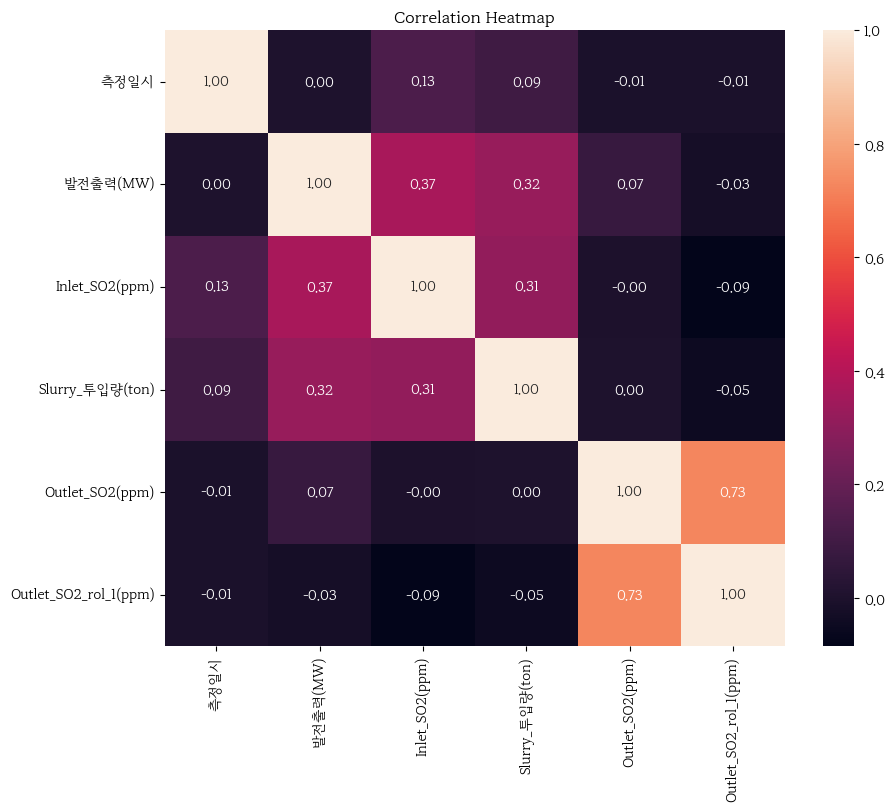

In [60]:
# 상관관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(result_df_clean_.corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## 군집분석

In [ ]:
from sklearn.cluster import KMeans

# 군집 분석
kmeans = KMeans(n_clusters=3)
result_df_clean['cluster'] = kmeans.fit_predict(result_df_clean[['Inlet_SO2(ppm)', 'Slurry_투입량(ton)', 'Outlet_SO2(ppm)', '발전출력(MW)']])

In [ ]:
plt.figure(figsize=(16, 12))
sns.relplot(
    data=result_df_clean, x='Inlet_SO2(ppm)', y='Slurry_투입량(ton)',
    col="cluster", hue="호기",
    kind="scatter"
)
plt.show()

## PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# PCA
scaler = StandardScaler()
scaled_df = scaler.fit_transform(result_df_clean[['Inlet_SO2(ppm)', 'Slurry_투입량(ton)', 'Outlet_SO2(ppm)', '발전출력(MW)']])
pca = PCA(n_components=2)
pca_df = pca.fit_transform(scaled_df)
result_df_clean['pca1'] = pca_df[:, 0]
result_df_clean['pca2'] = pca_df[:, 1]

In [ ]:
result_df_clean.columns

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=result_df_clean, x='pca1', y='pca2', style='cluster',hue='호기',alpha=0.3)
plt.title('PCA Clustering')
plt.show()

In [ ]:
plt.figure(figsize=(16, 12))
sns.relplot(
    data=result_df_clean, x='pca1', y='pca2',
    col="cluster", hue="호기",
    kind="scatter"
)
plt.show()

In [ ]:
# 클러스터별 숫자형 변수 통계 요약
cluster_summary = result_df_clean.groupby('cluster')[['발전출력(MW)', 'Inlet_SO2(ppm)', 'Slurry_투입량(ton)',
                                                     'Outlet_SO2(ppm)', 'pca1','pca2']].mean()
print(cluster_summary)

In [ ]:
# 변수 분포 시각화
for col in ['Inlet_SO2(ppm)', 'Slurry_투입량(ton)', 'Outlet_SO2(ppm)', '발전출력(MW)']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='cluster', y=col, data=result_df_clean)
    plt.title(f'Cluster-wise Distribution of {col}')
    plt.show()

In [ ]:
result_df_clean = result_df_clean.sort_values(by=['측정일시'], axis=0)

In [ ]:
# 클러스터별 시계열 분석
result_df_clean['측정일시'] = pd.to_datetime(result_df_clean['측정일시'])
for cluster in result_df_clean['cluster'].unique():
    cluster_df = result_df_clean[result_df_clean['cluster'] == cluster]
    plt.figure(figsize=(14, 8))
    plt.plot(cluster_df['측정일시'], cluster_df['Inlet_SO2(ppm)'], label=f'Cluster {cluster}')
    plt.title(f'Time Series of Inlet SO2 for Cluster {cluster}')
    plt.xlabel('Date')
    plt.ylabel('Inlet SO2(ppm)')
    plt.legend()
    plt.show()


# 모델 적용

## 다중회귀

Mean squared error: 10.250883029275402
Root mean squared error: 3.2017000217502267
R-squared: 0.08700780385844498
Inlet_SO2(ppm): 0.024668138345162894
Outlet_SO2_rol_1(ppm): -0.06922160002043297
Intercept: 2.4769253967740665


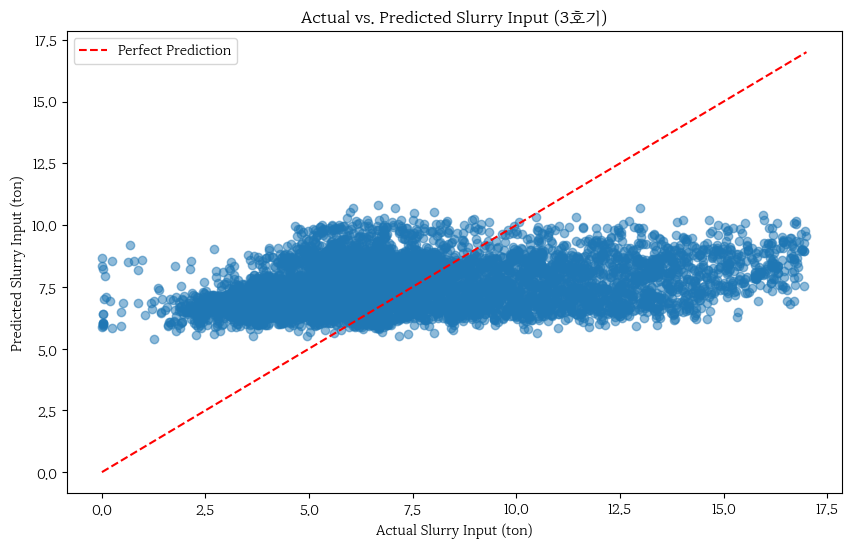

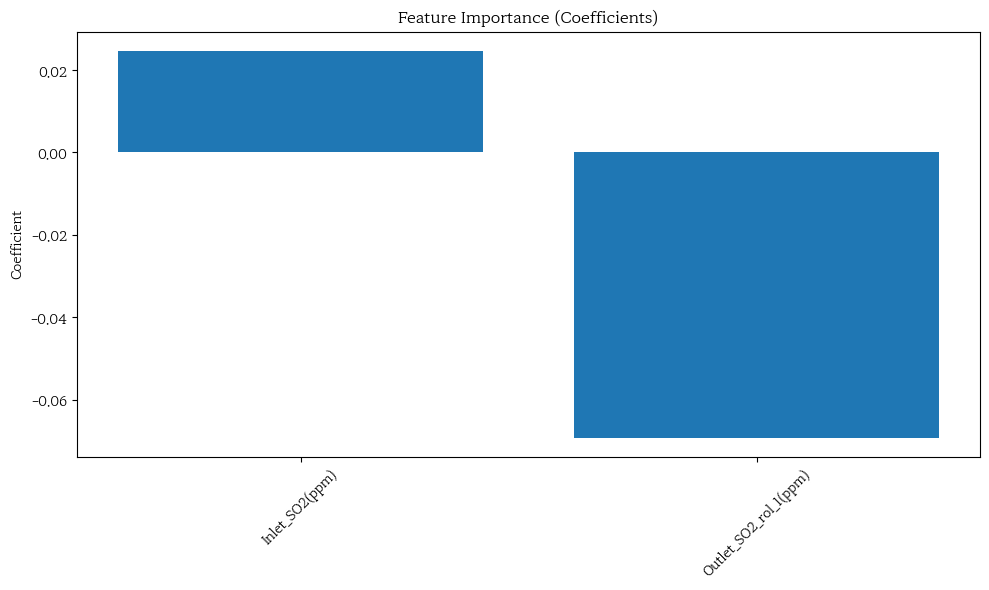

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 호기별로 모델을 만들기 위해 3호기 데이터만 선택
data_3 =result_df_clean[result_df_clean['호기'] == '3호기'].copy()

# 필요한 변수만 선택
features = ['Inlet_SO2(ppm)',  'Outlet_SO2_rol_1(ppm)']
target = 'Slurry_투입량(ton)'

X = data_3[features]
y = data_3[target]

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 다중 선형 회귀 모델 초기화 및 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse}")
print(f"Root mean squared error: {rmse}")
print(f"R-squared: {r2}")

# 각 변수의 계수와 절편 출력
for feature, coef in zip(features, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# 실제값과 예측값 비교 그래프
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Slurry Input (ton)')
plt.ylabel('Predicted Slurry Input (ton)')
plt.title('Actual vs. Predicted Slurry Input (3호기)')
plt.legend()
plt.show()

# 각 변수의 영향력을 시각화
plt.figure(figsize=(10, 6))
plt.bar(features, model.coef_)
plt.title('Feature Importance (Coefficients)')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Mean squared error: 7.362311604418047
Root mean squared error: 2.713357994150062
R-squared: 0.5361659055713321
Inlet_SO2(ppm): 0.027115594252445335
Outlet_SO2_rol_1(ppm): -0.026610052174787475
Intercept: -0.012190078432534612


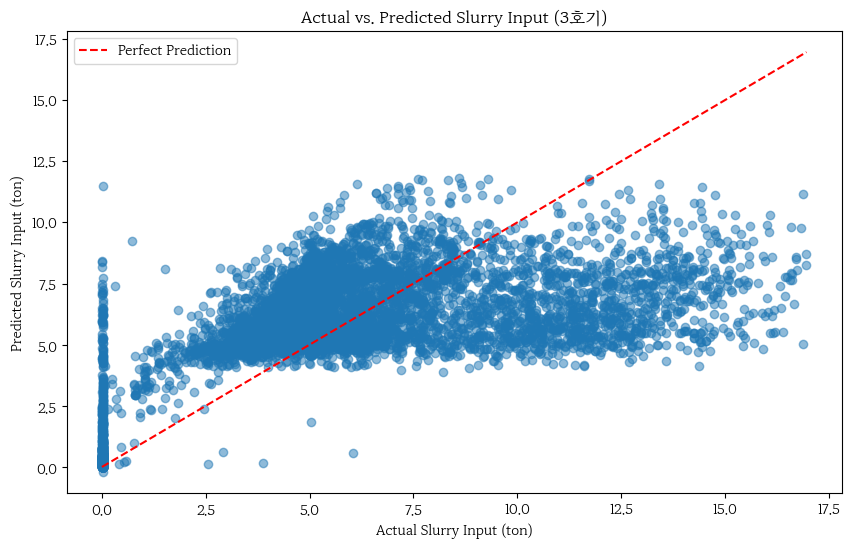

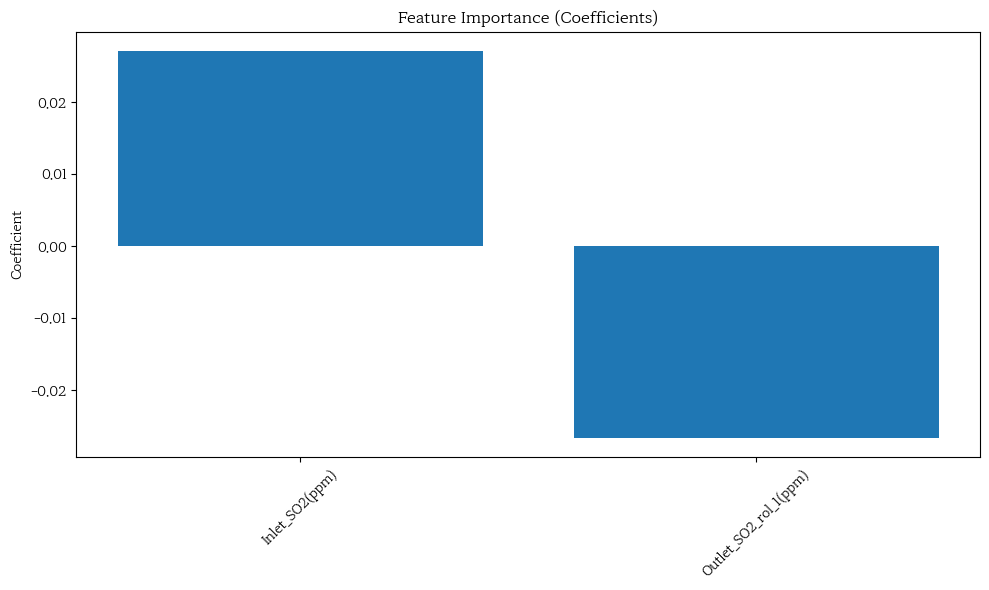

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 호기별로 모델을 만들기 위해 3호기 데이터만 선택
data_4 =result_df_clean[result_df_clean['호기'] == '4호기'].copy()

# 필요한 변수만 선택
features = ['Inlet_SO2(ppm)', 'Outlet_SO2_rol_1(ppm)']
target = 'Slurry_투입량(ton)'

X = data_4[features]
y = data_4[target]

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 다중 선형 회귀 모델 초기화 및 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse}")
print(f"Root mean squared error: {rmse}")
print(f"R-squared: {r2}")

# 각 변수의 계수와 절편 출력
for feature, coef in zip(features, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# 실제값과 예측값 비교 그래프
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Slurry Input (ton)')
plt.ylabel('Predicted Slurry Input (ton)')
plt.title('Actual vs. Predicted Slurry Input (3호기)')
plt.legend()
plt.show()

# 각 변수의 영향력을 시각화
plt.figure(figsize=(10, 6))
plt.bar(features, model.coef_)
plt.title('Feature Importance (Coefficients)')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Mean squared error: 13.066504941290722
Root mean squared error: 3.614762086402191
R-squared: 0.5878252179569008
Inlet_SO2(ppm): 0.0038691670307243256
발전출력(MW): 0.01857055789471954
Outlet_SO2_rol_1(ppm): 0.0008351082863075276
Intercept: -0.19902837117680328


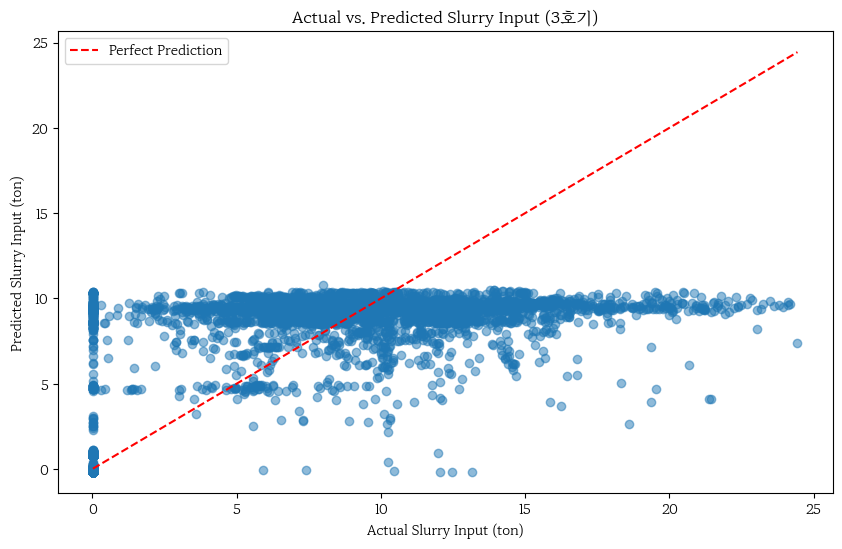

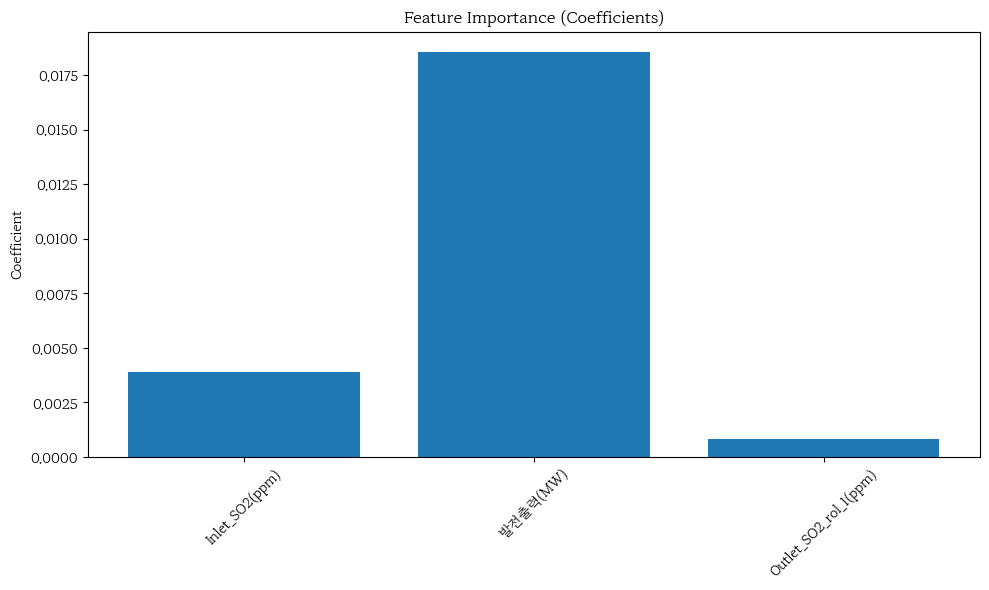

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 호기별로 모델을 만들기 위해 3호기 데이터만 선택
data_5 =result_df_clean[result_df_clean['호기'] == '5호기'].copy()

# 필요한 변수만 선택
features = ['Inlet_SO2(ppm)', '발전출력(MW)', 'Outlet_SO2_rol_1(ppm)']
target = 'Slurry_투입량(ton)'

X = data_5[features]
y = data_5[target]

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 다중 선형 회귀 모델 초기화 및 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse}")
print(f"Root mean squared error: {rmse}")
print(f"R-squared: {r2}")

# 각 변수의 계수와 절편 출력
for feature, coef in zip(features, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# 실제값과 예측값 비교 그래프
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Slurry Input (ton)')
plt.ylabel('Predicted Slurry Input (ton)')
plt.title('Actual vs. Predicted Slurry Input (3호기)')
plt.legend()
plt.show()

# 각 변수의 영향력을 시각화
plt.figure(figsize=(10, 6))
plt.bar(features, model.coef_)
plt.title('Feature Importance (Coefficients)')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Mean squared error: 153.38594200815967
Root mean squared error: 12.384907832041371
R-squared: 0.02811749736814806
Inlet_SO2(ppm): -0.018867418286887434
발전출력(MW): 0.06813415232760262
Outlet_SO2_rol_1(ppm): -0.08868823003490732
Intercept: -14.774562186944284


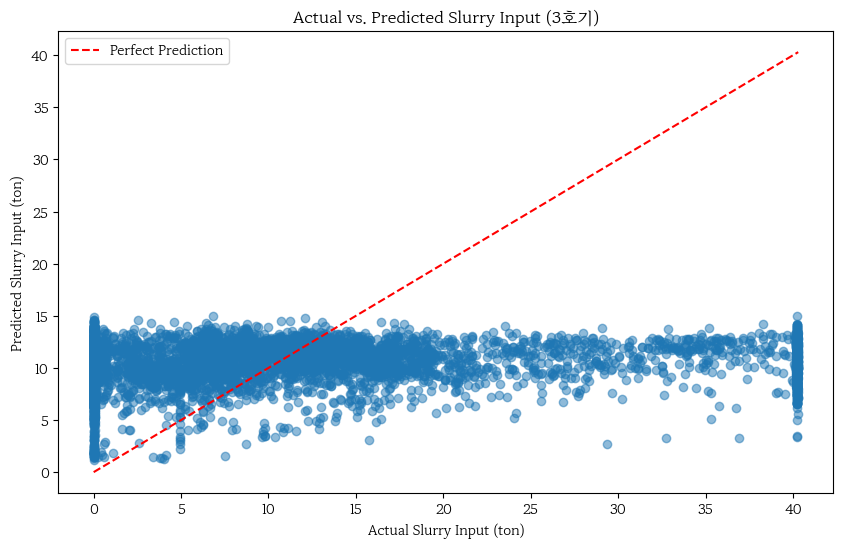

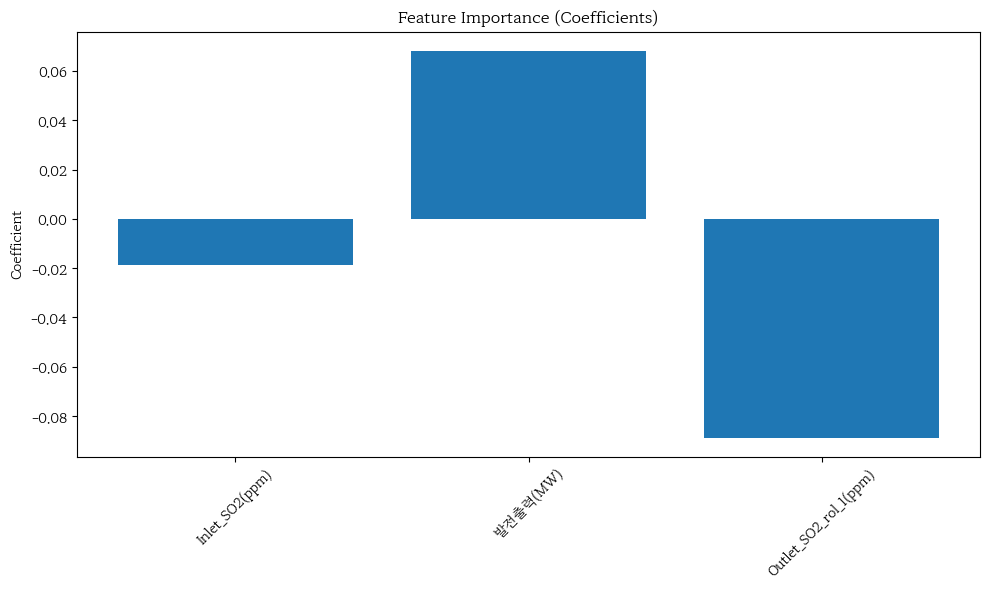

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 호기별로 모델을 만들기 위해 3호기 데이터만 선택
data_6 =result_df_clean[result_df_clean['호기'] == '6호기'].copy()

# 필요한 변수만 선택
features = ['Inlet_SO2(ppm)', '발전출력(MW)', 'Outlet_SO2_rol_1(ppm)']
target = 'Slurry_투입량(ton)'

X = data_6[features]
y = data_6[target]

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 다중 선형 회귀 모델 초기화 및 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse}")
print(f"Root mean squared error: {rmse}")
print(f"R-squared: {r2}")

# 각 변수의 계수와 절편 출력
for feature, coef in zip(features, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# 실제값과 예측값 비교 그래프
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Slurry Input (ton)')
plt.ylabel('Predicted Slurry Input (ton)')
plt.title('Actual vs. Predicted Slurry Input (3호기)')
plt.legend()
plt.show()

# 각 변수의 영향력을 시각화
plt.figure(figsize=(10, 6))
plt.bar(features, model.coef_)
plt.title('Feature Importance (Coefficients)')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 랜덤 포레스트(Random Forest)

In [58]:
result_df_clean.columns

Index(['측정일시', '호기', '발전출력(MW)', '운전상태', 'Inlet_SO2(ppm)', 'Slurry_투입량(ton)',
       'Outlet_SO2(ppm)', 'Outlet_SO2_rol_1(ppm)'],
      dtype='object')

In [59]:
result_df_clean['호기'].unique()

array(['3호기', '4호기', '5호기', '6호기'], dtype=object)

In [60]:
result_df_clean.loc[result_df_clean['호기']=="3호기",'호기'] = 3
result_df_clean.loc[result_df_clean['호기']=="4호기",'호기'] = 4
result_df_clean.loc[result_df_clean['호기']=="5호기",'호기'] = 5
result_df_clean.loc[result_df_clean['호기']=="6호기",'호기'] = 6

In [61]:
result_df_clean['호기'].unique()

array([3, 4, 5, 6], dtype=object)

Mean Absolute Error: 3.7440303071432552
Mean Squared Error: 43.88741658085273
Root Mean Squared Error: 6.624757850733318
R-squared: 0.23040242741156436


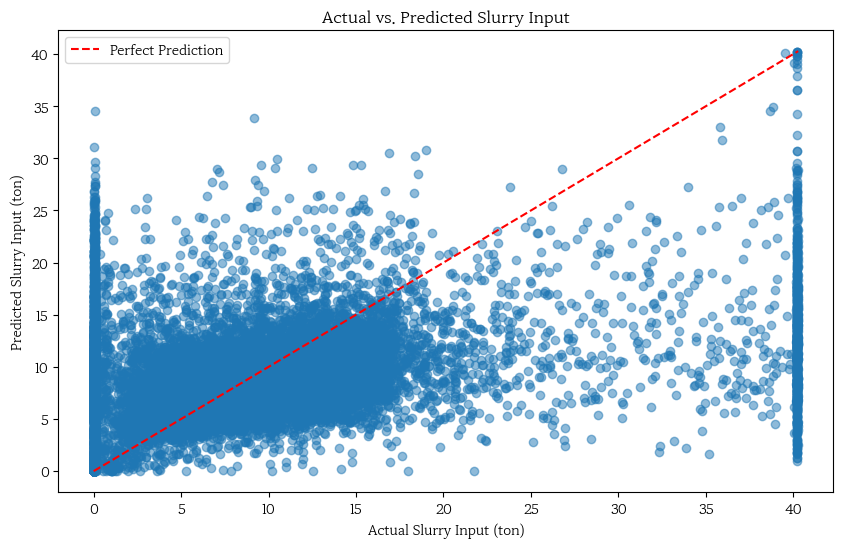

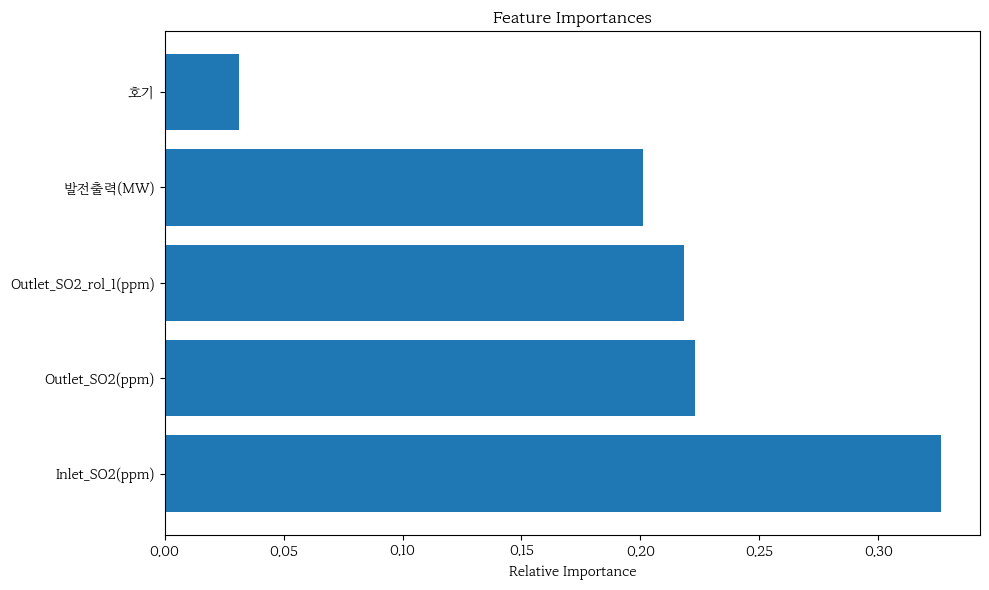

ValueError: X has 3 features, but StandardScaler is expecting 5 features as input.

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = result_df_clean

# 특성(X)과 타겟(y) 분리
X = data[['호기','Inlet_SO2(ppm)', '발전출력(MW)', 'Outlet_SO2(ppm)', 'Outlet_SO2_rol_1(ppm)']]
y = data['Slurry_투입량(ton)']

# 데이터 분할 (학습 80%, 테스트 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링 (Random Forest에는 필수는 아니지만, 변수 중요도 해석에 도움)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 랜덤 포레스트 모델 초기화 및 학습
model = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, 
                           min_samples_leaf=1, bootstrap=True, random_state=42)
model.fit(X_train_scaled, y_train)

# 테스트 세트에 대한 예측
y_pred = model.predict(X_test_scaled)

# 모델 성능 평가
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

# 실제값과 예측값 비교 플롯
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Slurry Input (ton)")
plt.ylabel("Predicted Slurry Input (ton)")
plt.title("Actual vs. Predicted Slurry Input")
plt.legend()
plt.show()

# 변수 중요도 시각화
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(X.shape[1]), importances[indices], align='center')
plt.yticks(range(X.shape[1]), feature_names)
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

# 최적의 Slurry 투입량 예측 함수
def predict_optimal_slurry(inlet_so2, power_output, target_outlet_so2):
    input_data = np.array([[inlet_so2, power_output, target_outlet_so2]])
    input_data_scaled = scaler.transform(input_data)
    return model.predict(input_data_scaled)[0]

# 예: Inlet SO2가 1000ppm, 발전 출력이 500MW일 때, 목표 Outlet SO2를 20ppm으로 유지하기 위한 최적 Slurry 투입량
optimal_slurry = predict_optimal_slurry(1000, 500, 20)
print(f"최적 Slurry 투입량: {optimal_slurry} ton")

## 그래디언트 부스팅 머신 (Gradient Boosting Machine, GBM)

In [ ]:
%%time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import shap

data = result_df_clean

# 특성(X)과 타겟(y) 분리
X = data[['호기','Inlet_SO2(ppm)', '발전출력(MW)', 'Outlet_SO2(ppm)', 'Outlet_SO2_rol_1(ppm)']]
y = data['Slurry_투입량(ton)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost 모델
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)

# XGBoost 하이퍼파라미터 튜닝
xgb_param_dist = {
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

xgb_search = RandomizedSearchCV(xgb_model, xgb_param_dist, n_iter=50, cv=5, random_state=42, n_jobs=-1)
xgb_search.fit(X_train_scaled, y_train)

# 최적의 XGBoost 모델로 예측
xgb_best = xgb_search.best_estimator_
xgb_pred = xgb_best.predict(X_test_scaled)

# XGBoost 모델 성능 평가
print("XGBoost Model Performance:")
print(f"  MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"  MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"  R-squared: {r2_score(y_test, xgb_pred)}\n")

# LightGBM 모델
lgb_model = lgb.LGBMRegressor(objective='regression', n_estimators=100, learning_rate=0.1, random_state=42)

# LightGBM 하이퍼파라미터 튜닝
lgb_param_dist = {
    'max_depth': [-1, 3, 5, 7, 10],  # -1 means no limit
    'num_leaves': [31, 50, 100, 200],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

lgb_search = RandomizedSearchCV(lgb_model, lgb_param_dist, n_iter=50, cv=5, random_state=42, n_jobs=-1)
lgb_search.fit(X_train_scaled, y_train)

# 최적의 LightGBM 모델로 예측
lgb_best = lgb_search.best_estimator_
lgb_pred = lgb_best.predict(X_test_scaled)

# LightGBM 모델 성능 평가
print("LightGBM Model Performance:")
print(f"  MAE: {mean_absolute_error(y_test, lgb_pred)}")
print(f"  MSE: {mean_squared_error(y_test, lgb_pred)}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, lgb_pred))}")
print(f"  R-squared: {r2_score(y_test, lgb_pred)}\n")

# 모델 비교를 위한 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, xgb_pred, alpha=0.5, label='XGBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Slurry Input (ton)")
plt.ylabel("Predicted Slurry Input (ton)")
plt.title("XGBoost: Actual vs. Predicted")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, lgb_pred, alpha=0.5, label='LightGBM')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Slurry Input (ton)")
plt.ylabel("Predicted Slurry Input (ton)")
plt.title("LightGBM: Actual vs. Predicted")
plt.legend()

plt.tight_layout()
plt.show()

# SHAP 값을 사용한 모델 해석 (LightGBM 모델 사용)
explainer = shap.TreeExplainer(lgb_best)
shap_values = explainer.shap_values(X_test_scaled)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
plt.title("LightGBM: SHAP Value Summary")
plt.tight_layout()
plt.show()

# 특정 예측에 대한 SHAP 값 설명
i = 0  # 첫 번째 테스트 샘플을 선택
plt.figure(figsize=(10, 3))
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i], feature_names=X.columns, matplotlib=True)
plt.title(f"SHAP Force Plot for Sample {i}")
plt.tight_layout()
plt.show()

# 최적의 Slurry 투입량 예측 함수 (LightGBM 모델 사용)
def predict_optimal_slurry_lgb(inlet_so2, power_output, target_outlet_so2):
    input_data = np.array([[inlet_so2, power_output, target_outlet_so2]])
    input_data_scaled = scaler.transform(input_data)
    return lgb_best.predict(input_data_scaled)[0]

# 예: Inlet SO2가 1000ppm, 발전 출력이 500MW일 때, 목표 Outlet SO2를 20ppm으로 유지하기 위한 최적 Slurry 투입량
optimal_slurry = predict_optimal_slurry_lgb(1000, 500, 20)
print(f"LightGBM 모델이 예측한 최적 Slurry 투입량: {optimal_slurry} ton")

# 투입량에 따른 Outlet SO2의 변화 시뮬레이션
inlet_so2 = 1000
power_output = 500
slurry_inputs = np.linspace(0, 50, 100)  # 0에서 50 ton 사이의 100개 값

outlet_so2_predictions = []
for slurry in slurry_inputs:
    input_data = np.array([[inlet_so2, power_output, slurry]])
    input_data_scaled = scaler.transform(input_data)
    outlet_so2_predictions.append(lgb_best.predict(input_data_scaled)[0])

plt.figure(figsize=(10, 6))
plt.plot(slurry_inputs, outlet_so2_predictions, label='Predicted Outlet SO2')
plt.axhline(y=20, color='r', linestyle='--', label='Target (20 ppm)')
plt.xlabel('Slurry Input (ton)')
plt.ylabel('Outlet SO2 (ppm)')
plt.title(f'Inlet SO2: {inlet_so2} ppm, Power Output: {power_output} MW')
plt.grid()
plt.legend()
plt.show()

In [ ]:
result_df_clean.info()

## GBM과 시계열 모델을 앙상블

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 1. 시계열 모델 학습 및 예측
ts_model = ARIMA(train['target_variable'], order=(5, 1, 0))
ts_model_fit = ts_model.fit(disp=0)
ts_train_pred = ts_model_fit.predict(start=0, end=len(train)-1, dynamic=False)
ts_test_pred = ts_model_fit.forecast(steps=len(test))[0]

# 2. GBM 학습 및 예측
features = ['feature1', 'feature2']
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gbm.fit(train[features], train['target_variable'])
gbm_train_pred = gbm.predict(train[features])
gbm_test_pred = gbm.predict(test[features])

# 3. 메타 모델 학습
meta_train_features = np.column_stack((ts_train_pred, gbm_train_pred))
meta_test_features = np.column_stack((ts_test_pred, gbm_test_pred))
meta_model = LinearRegression()
meta_model.fit(meta_train_features, train['target_variable'])

# 4. 최종 예측
final_pred = meta_model.predict(meta_test_features)


In [ ]:
# 그래프 그리면서 분 정보 없어졌나 확인
result_df_clean.head()

In [ ]:
# arima model index?
result_df_clean.groupby(['측정일시']).count()

In [ ]:
result_df_clean_3 = result_df_clean[result_df_clean['호기']=="3호기"]
result_df_clean_3.shape

In [ ]:
result_df_clean_3.info()

In [ ]:
# 중복된 인덱스 제거
result_df_clean_3 = result_df_clean_3.drop_duplicates(subset=['측정일시'])

# 날짜를 인덱스로 설정
result_df_clean_3 = result_df_clean_3.set_index('측정일시').sort_index()

In [ ]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# 학습 및 테스트 데이터 분할
train_data, test_data = train_test_split(result_df_clean, test_size=0.2, shuffle=False, stratify=None)

# 시계열 데이터 추출
train_ts = train_data['Inlet_SO2(ppm)']
test_ts = test_data['Inlet_SO2(ppm)']

In [ ]:
test_ts

In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [ ]:
# ARIMA 모델 학습
arima_model = ARIMA(train_ts, order=(5, 1, 0))
arima_model_fit = arima_model.fit()

# ARIMA 예측
train_data['ts_pred'] = arima_model_fit.predict(start=train_ts.index[0], end=train_ts.index[-1], dynamic=False)
test_data['ts_pred'] = arima_model_fit.predict(steps=len(test_ts))

# 인덱스 리셋
train_data = train_data.reset_index()
test_data = test_data.reset_index()

In [ ]:
train_data.head()

In [ ]:
test_data.info()

In [ ]:
test_data[features].isnull().sum()

In [ ]:
# GBM 모델을 위한 피쳐 선택
features = ['발전출력(MW)', 'Slurry_투입량(ton)', 'ts_pred']

# GBM 모델 학습
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gbm.fit(train_data[features], train_data['Outlet_SO2(ppm)'])

# GBM 예측
train_data['gbm_pred'] = gbm.predict(train_data[features])
test_data['gbm_pred'] = gbm.predict(test_data[features])

In [ ]:
# 메타 모델 학습
meta_features_train = np.column_stack((train_data['ts_pred'], train_data['gbm_pred']))
meta_features_test = np.column_stack((test_data['ts_pred'], test_data['gbm_pred']))

meta_model = LinearRegression()
meta_model.fit(meta_features_train, train_data['Outlet_SO2(ppm)'])

# 최종 예측
final_pred = meta_model.predict(meta_features_test)

In [ ]:
test_data['final_pred'] = final_pred

# 결과 시각화 또는 평가

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Outlet_SO2(ppm)'], label='Actual')
plt.plot(test_data.index, test_data['final_pred'], label='Predicted', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Outlet SO2(ppm)')
plt.show()

# 평가 지표 계산 (예: RMSE)
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test_data['Outlet_SO2(ppm)'], test_data['final_pred']))
print(f'RMSE: {rmse}')